<a href="https://colab.research.google.com/github/abubakrsiddq/ImageDehazing/blob/main/models/novel/anet_subclass_may15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow_addons
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import random
from PIL import Image
import time
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.optimizers import Adam
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_image(img_path):
    img = tf.io.read_file(img_path)
    #img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.io.decode_png(img, channels = 3)
    img = tf.image.resize(img, size = (352, 1216), antialias = True)
    img = img / 255.0
    return img

In [ ]:
def load_airlight(img_path):
  air=img_path.split("_")[-1][:-4];
  return air

In [ ]:
def display_img(model, hazy_img, orig_img):
    pred = model(hazy_img)
    plt.figure(figsize = (15,15))
    
    display_list = [hazy_img[0], orig_img[0], pred[0]]
    title = ['Hazy Image', 'Ground Truth', 'Dehazed Image']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
        
    plt.show()

In [ ]:
def data_path(hazy_img_path,percentage=0.8,seed_val=101):
    
    random.seed(seed_val)
    train_img = []
    val_img = []
    train_air= []
    val_air= []
    
    
    #hazy_img = glob.glob(hazy_img_path + '/*.jpg')
    hazy_img = glob.glob(hazy_img_path + '/*.png')
    n = len(hazy_img)
    n1=percentage*n;

    random.shuffle(hazy_img)
    n=n1;
    train_keys = hazy_img[:int(0.9*n)]        #90% data for train, 10% for test
    val_keys = hazy_img[int(0.9*n):int(1.0*n)]
    #hazy_img=hazy_img[:n]
    split_dict = {}
    for key in train_keys:
        split_dict[key] = 'train'
    for key in val_keys:
        split_dict[key] = 'val'
        
    
    for img in hazy_img:
        air=img.split("_")[-1][:-4];
  
        try:
          if (split_dict[img] == 'train'):
              train_air.append(float(air))
              train_img.append(img)
          else:
              val_air.append(float(air))
              val_img.append(img)
        except KeyError:
          pass
    return train_img,train_air, val_img,val_air

In [ ]:
def dataloader(train_data,train_res, val_data,val_res, batch_size):
    print(len(train_data))
    train_data_haze = tf.data.Dataset.from_tensor_slices([img for img in train_data]).map(lambda x: load_image(x))
    train_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in train_res])
    train = tf.data.Dataset.zip((train_data_haze,train_data_airlight)).shuffle(100).batch(batch_size)

    val_data_haze = tf.data.Dataset.from_tensor_slices([img for img in val_data]).map(lambda x: load_image(x))
    val_data_airlight = tf.data.Dataset.from_tensor_slices([a for a in val_res])
    val = tf.data.Dataset.zip((val_data_haze,val_data_airlight)).shuffle(100).batch(batch_size)

    

    

    return train, val

In [ ]:
class A_net(tf.keras.Model):
  def __init__(self):
    super(A_net,self).__init__()
    self.conv1 = Conv2D(input_shape = (413, 550, 3), filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.Maxout=tfa.layers.Maxout(num_units=4,axis= -1)
    self.conv2 = Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'same', use_bias = True)
    self.conv3 = Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'same', use_bias = True)
    self.conv4 = Conv2D(filters = 16, kernel_size = 7, strides = 1, padding = 'same', use_bias = True)
    self.maxpool=MaxPool2D(7,strides=1,padding='same')
    self.conv5 = Conv2D(filters = 1, kernel_size = 6, strides = 1, padding = 'same', use_bias = True)
    self.flatten= tf.keras.layers.Flatten()
    #self.dense1=tf.keras.layers.Dense(100,activation='relu')
    self.dense2=tf.keras.layers.Dense(1,activation='relu')


  def call(self,inputs):
    out = self.conv1(inputs)
    out = self.Maxout(out)
    out1 = self.conv2(out)
    out2 = self.conv3(out)
    out3 = self.conv4(out)
    y=tf.keras.layers.concatenate([out1,out2,out3])
    y = self.maxpool(y)
    y = self.conv5(y)
    #print(y.shape)
    y= ReLU()(y)
    y= self.flatten(y)
    #y=self.dense1(y)
    y=self.dense2(y)
    return y

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output
  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 352, 1216, 3 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 352, 1216, 16 1216        input_1[0][0]                    
__________________________________________________________________________________________________
maxout (Maxout)                 (None, 352, 1216, 4) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 1216, 16 592         maxout[0][0]                     
______________________________________________________________________________________________

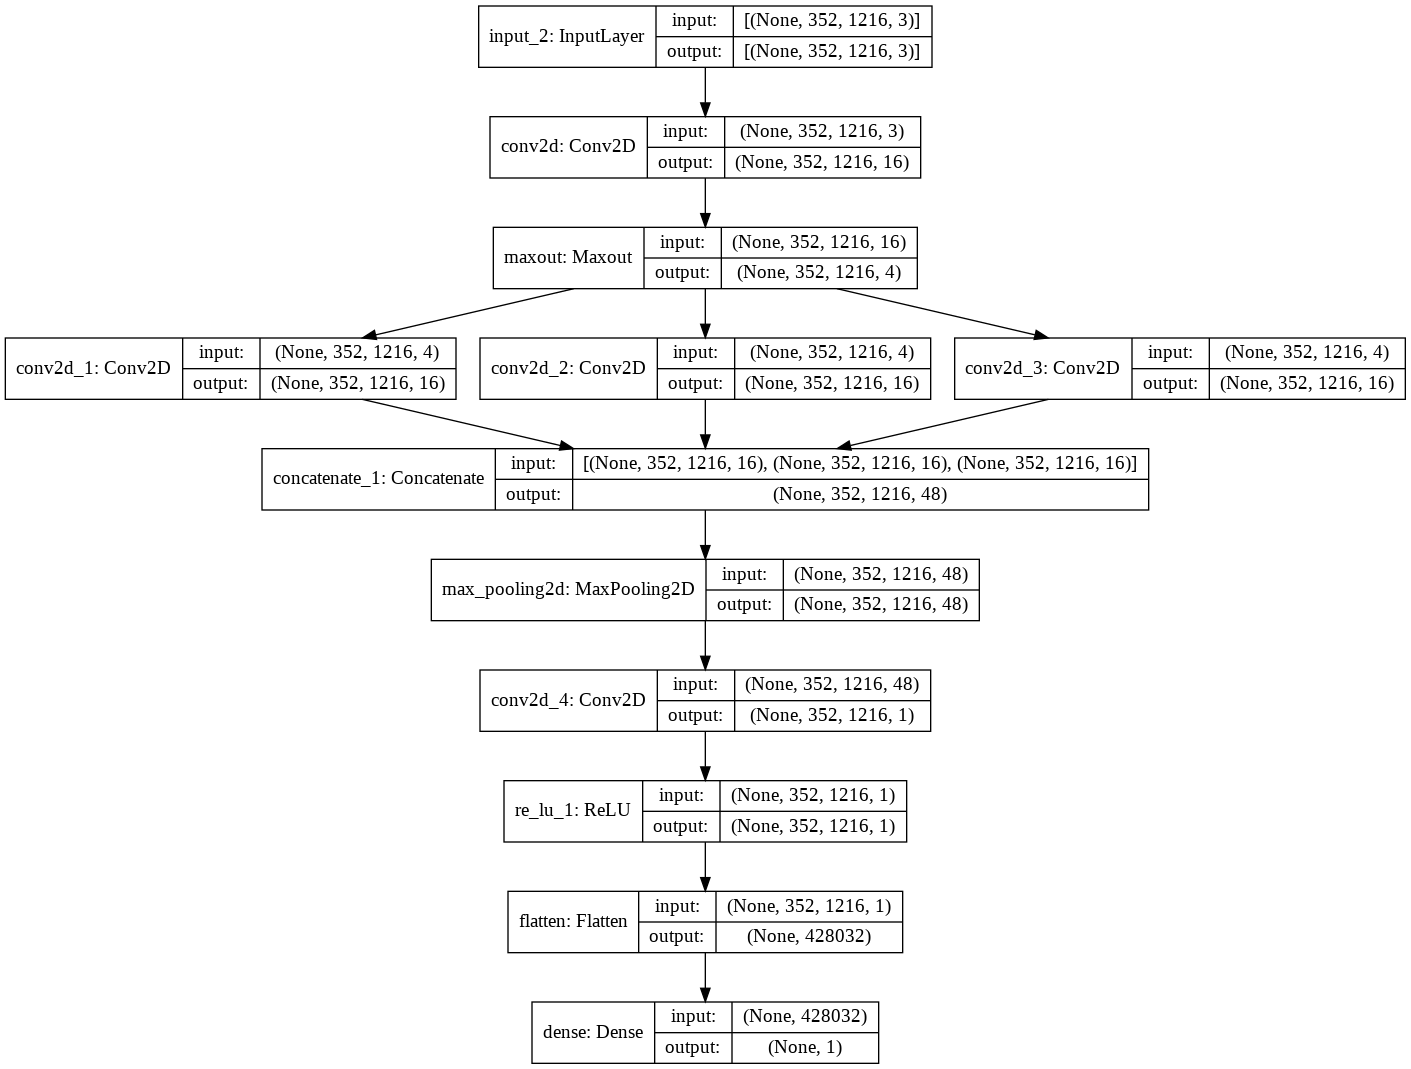

In [ ]:
model=A_net()

model.model().summary()
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model.build_graph(), to_file=dot_img_file, show_shapes=True)

In [ ]:
class A_net(tf.keras.Model):
  def __init__(self):
    super(A_net,self).__init__()
    self.seq = tf.keras.Sequential()

    # 1st conv layer
    self.seq.add(tf.keras.layers.Conv2D(input_shape=(None, None, 3),filters=32,kernel_size= (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    self.seq.add(keras.layers.Conv2D(16, (3, 3), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    self.seq.add(keras.layers.Conv2D(8, (2, 2), activation='relu'))
    self.seq.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    self.seq.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    self.seq.add(keras.layers.Flatten())
    
    # 1st dense layer
    self.dense1=keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop1=keras.layers.Dropout(0.6)

    # 2nd dense layer
    self.dense2=keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))
    self.drop2=keras.layers.Dropout(0.5)

    # 3rd dense layer
    self.dense3=keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))
    self.drop3=keras.layers.Dropout(0.2)


    # output layer
    self.out=keras.layers.Dense(1, activation='relu')



  def call(self,inputs,train=True):
    x=self.seq(inputs)
    x=self.dense1(x)
    x=self.drop1(x,train)
    x=self.dense2(x)
    x=self.drop2(x,train)
    x=self.dense3(x)
    x=self.drop3(x,train)
    return self.out(x)

   #K = conv5
   #output = ReLU(max_value = 1.0)(tf.math.multiply(K,inputs) - K + 1.0)
   #output1=tf.image.resize_with_crop_or_pad(output1, 412, 548)
   #output=tf.image.resize(output1, size = (413, 550), antialias = True)
   #model = Model(inputs = x, outputs = output)
   
   #return output

  def model(self):
        x = Input(shape = (352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

    
  def build_graph(self):
        x = Input(shape=(352, 1216, 3))
        return Model(inputs=[x], outputs=self.call(x))

In [ ]:
net = A_net()

In [ ]:
# Hyperparameters
epochs = 20
batch_size = 4
k_init = tf.keras.initializers.random_normal(stddev=0.008, seed = 101)      
regularizer = tf.keras.regularizers.L2(1e-4)
b_init = tf.constant_initializer()

train_data,train_res, val_data,val_res = data_path(hazy_img_path = '/content/drive/MyDrive/kitti/hazy',percentage=0.1)
train, val = dataloader(train_data,train_res, val_data,val_res, batch_size)

optimizer = Adam(learning_rate = 1e-5)
#net = A_net()
train_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "train loss")
val_loss_tracker = tf.keras.metrics.MeanSquaredError(name = "val loss")

540


In [ ]:
def train_model(epochs, train, val, net, train_loss_tracker, val_loss_tracker, optimizer):
    
    for epoch in range(epochs):
        
        print("\nStart of epoch %d" % (epoch,), end=' ')
        start_time_epoch = time.time()
        start_time_step = time.time()

        for step, (train_batch_haze, train_res) in enumerate(train):

            with tf.GradientTape() as tape:

                train_logits = net(train_batch_haze, training = True)
                #print(train_logits.shape)
                train_res=np.expand_dims(train_res,axis=-1)
                loss = mean_squared_error(train_res, train_logits)

            grads = tape.gradient(loss, net.trainable_weights)
            optimizer.apply_gradients(zip(grads, net.trainable_weights))
            
            train_loss_tracker.update_state(train_res, train_logits)
            if step == 0:
                print('[', end='')
            if step % 64 == 0:
                print('=', end='')
        
        print(']', end='')
        print('  -  ', end='')
        print('Training Loss: %.4f' % (train_loss_tracker.result()), end='')
        
        for step, (val_batch_haze, val_res) in enumerate(val):
            val_logits = net(val_batch_haze, training = False)
            val_res=np.expand_dims(val_res,axis=-1)
            #print(val_logits.shape)
            #print("---------------------")
            val_loss_tracker.update_state(val_res, val_logits)
            #if step % 64 ==0:
                #display_img(net, val_batch_haze, val_batch_orig)
        print('  -  ', end='')
        print('Validation Loss: %.4f' % (val_loss_tracker.result()), end='')
        print('  -  ', end=' ')
        print("Time taken: %.2fs" % (time.time() - start_time_epoch))
        
        train_loss_tracker.reset_states()
        val_loss_tracker.reset_states()

In [ ]:
%%time
train_model(3, train, val, net, train_loss_tracker, val_loss_tracker, tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True))


Start of epoch 0 [=

In [ ]:
optimizer = Adam(learning_rate = 1e-7)

In [ ]:
%%time
train_model(20, train, val, net, train_loss_tracker, val_loss_tracker, optimizer)


Start of epoch 0 [===]  -  Training Loss: 0.6630  -  Validation Loss: 0.6508  -   Time taken: 165.30s

Start of epoch 1 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 170.84s

Start of epoch 2 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 166.15s

Start of epoch 3 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 164.41s

Start of epoch 4 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 164.65s

Start of epoch 5 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 164.49s

Start of epoch 6 [===]  -  Training Loss: 0.6628  -  Validation Loss: 0.6508  -   Time taken: 164.59s

Start of epoch 7 [=

KeyboardInterrupt: ignored